In [ ]:
from google.cloud import storage
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from io import BytesIO

# Initialize connection to buckets
client = storage.Client(project='quantum-brain-models')
results_bucket = client.bucket('quantum-sfa-results')

# Create a session ID for this test run
SESSION_ID = datetime.now().strftime('%Y%m%d_%H%M%S')
SESSION_NAME = "baseline_test_1"  # Change this for different test runs

print(f"📁 Session: {SESSION_NAME}_{SESSION_ID}")

def save_results_and_figures(results, test_name, figures=None):
    """Enhanced save function with proper organization"""
    timestamp = datetime.now().strftime('%H%M%S')  # Just time since date is in session
    
    # Add metadata
    results['metadata'] = {
        'test_name': test_name,
        'timestamp': datetime.now().isoformat(),
        'model_version': '4.0',
        'session_id': SESSION_ID,
        'grid_size': getattr(globals().get('params', None), 'grid_size', 50)
    }
    
    # Calculate summary metrics if available
    if 'posner_field' in results and results['posner_field'] is not None:
        results['summary'] = {
            'peak_posner_nM': np.max(results['posner_field']) * 1e9,
            'mean_posner_nM': np.mean(results['posner_field']) * 1e9,
        }
    
    # Convert numpy arrays to lists for JSON
    data_for_json = {}
    for key, value in results.items():
        if isinstance(value, np.ndarray):
            data_for_json[key] = value.tolist()
        elif isinstance(value, dict):
            # Recursively convert nested dicts
            nested = {}
            for k, v in value.items():
                if isinstance(v, np.ndarray):
                    nested[k] = v.tolist()
                else:
                    nested[k] = v
            data_for_json[key] = nested
        else:
            data_for_json[key] = value
    
    # Organized path structure: model4/SESSION/test_name/files
    base_path = f"model4/{SESSION_NAME}_{SESSION_ID}/{test_name}_{timestamp}"
    
    # Save data
    data_path = f"{base_path}/data.json"
    blob = results_bucket.blob(data_path)
    blob.upload_from_string(json.dumps(data_for_json, indent=2, default=str))
    print(f"✅ Data saved: {data_path}")
    
    # Save current matplotlib figure
    if plt.get_fignums():
        fig_path = f"{base_path}/figure.png"
        buf = BytesIO()
        plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        
        blob = results_bucket.blob(fig_path)
        blob.upload_from_file(buf, content_type='image/png')
        print(f"✅ Figure saved: {fig_path}")
    
    # Save additional figures if provided
    if figures:
        for i, fig in enumerate(figures):
            fig_path = f"{base_path}/figure_{i}.png"
            buf = BytesIO()
            fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
            buf.seek(0)
            
            blob = results_bucket.blob(fig_path)
            blob.upload_from_file(buf, content_type='image/png')
            print(f"✅ Extra figure {i} saved: {fig_path}")
    
    return base_path

# Create a session summary file
def save_session_summary(test_results_list):
    """Save a summary of all tests in this session"""
    summary = {
        'session_id': SESSION_ID,
        'session_name': SESSION_NAME,
        'date': datetime.now().isoformat(),
        'total_tests': len(test_results_list),
        'tests': test_results_list
    }
    
    summary_path = f"model4/{SESSION_NAME}_{SESSION_ID}/session_summary.json"
    blob = results_bucket.blob(summary_path)
    blob.upload_from_string(json.dumps(summary, indent=2, default=str))
    print(f"📊 Session summary saved: {summary_path}")

print("✅ Google Cloud connection established")
print(f"✅ Connected to bucket: {results_bucket.name}")
print(f"📁 All results will be saved to: model4/{SESSION_NAME}_{SESSION_ID}/")

📁 Session: baseline_test_1_20250823_092906
✅ Google Cloud connection established
✅ Connected to bucket: quantum-sfa-results
📁 All results will be saved to: model4/baseline_test_1_20250823_092906/


In [61]:
import subprocess
import sys

try:
    from google.cloud import bigquery
    print("✅ google-cloud-bigquery already installed")
except ImportError:
    print("Installing google-cloud-bigquery...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "google-cloud-bigquery"])
    print("✅ Installation complete")

# Import BigQuery
from google.cloud import bigquery
import uuid

# Initialize BigQuery client
bq_client = bigquery.Client(project='quantum-sfa-phd')
print("✅ BigQuery client initialized")

def save_test_to_bigquery(results, test_name, session_id, session_name, params=None):
    """
    Save test results to BigQuery tables
    
    Args:
        results: Dictionary containing test results
        test_name: Name of the test
        session_id: Session ID from GCS
        session_name: Session name
        params: Model parameters dictionary
    """
    
    # Generate unique test ID
    test_id = str(uuid.uuid4())
    
    # Prepare row for test_runs table
    test_run_row = {
        'test_id': test_id,
        'session_id': session_id,
        'session_name': session_name,
        'model_name': 'DynamicNanoreactor',
        'model_version': '4.1',
        'test_name': test_name,
        'timestamp': datetime.now().isoformat(),
        'stim_protocol': results.get('stim_protocol', 'baseline'),
        'duration': results.get('duration', 0.0),
        
        # Core metrics - handle both nM and M units
        'peak_posner_nM': results.get('peak_posner_nM', results.get('peak_nM', 0.0)),
        'mean_posner_nM': results.get('mean_posner_nM', results.get('mean_nM', 0.0)),
        'peak_pnc_nM': results.get('peak_pnc_nM', results.get('mean_pnc', 0.0) * 1e9),
        'mean_pnc_nM': results.get('mean_pnc_nM', results.get('mean_pnc', 0.0) * 1e9),
        'peak_calcium_uM': results.get('peak_calcium_uM', 0.0),
        'mean_calcium_uM': results.get('mean_calcium_uM', 0.0),
        
        # Spatial metrics
        'hotspot_lifetime': results.get('hotspot_lifetime', 0.0),
        'spatial_heterogeneity': results.get('spatial_heterogeneity', 0.0),
        'n_hotspots': results.get('n_hotspots', 0),
        'spatial_cv': results.get('spatial_cv', 0.0),
        
        # Conservation metrics
        'calcium_conservation': results.get('calcium_conservation', 1.0),
        'phosphate_conservation': results.get('phosphate_conservation', 1.0),
        
        # Template and fusion metrics
        'templates_occupied': results.get('templates_occupied', 0),
        'fusion_events': results.get('fusion_events', 0),
        
        # GCS paths - construct from session info
        'gcs_data_path': f"gs://quantum-sfa-results/model4/{session_name}_{session_id}/{test_name}/data.json",
        'gcs_hdf5_path': f"gs://quantum-sfa-results/model4/{session_name}_{session_id}/{test_name}/data.h5",
        'gcs_json_path': f"gs://quantum-sfa-results/model4/{session_name}_{session_id}/{test_name}/results.json",
        
        # Test result
        'test_passed': results.get('test_passed', True)
    }
    
    # Insert into test_runs table
    table_id = 'quantum-sfa-phd.model_results.test_runs'
    table = bq_client.get_table(table_id)
    
    import json
    test_run_row_json = json.loads(json.dumps(test_run_row, default=str))
    errors = bq_client.insert_rows_json(table, [test_run_row_json])
    
    if errors:
        print(f"❌ Error inserting test run: {errors}")
    else:
        print(f"✅ Test run saved to BigQuery: {test_id}")
    
    # Save parameters if provided
    if params:
        param_row = {
            'test_id': test_id,
            'grid_size': params.get('grid_size', 50),
            'active_zone_radius': params.get('active_zone_radius', 0.0),
            'cleft_width': params.get('cleft_width', 0.0),
            'n_channels': params.get('n_channels', 0),
            'channel_current': params.get('channel_current', 0.0),
            'channel_open_rate': params.get('channel_open_rate', 0.0),
            'channel_close_rate': params.get('channel_close_rate', 0.0),
            'ca_baseline': params.get('ca_baseline', 0.0),
            'po4_baseline': params.get('po4_baseline', 0.0),
            'atp_concentration': params.get('atp_concentration', 0.0),
            'pnc_baseline': params.get('pnc_baseline', 0.0),
            'D_calcium': params.get('D_calcium', 0.0),
            'D_phosphate': params.get('D_phosphate', 0.0),
            'D_pnc': params.get('D_pnc', 0.0),
            'D_posner': params.get('D_posner', 0.0),
            'k_complex_formation': params.get('k_complex_formation', 0.0),
            'k_complex_dissociation': params.get('k_complex_dissociation', 0.0),
            'k_pnc_formation': params.get('k_pnc_formation', 0.0),
            'k_pnc_dissolution': params.get('k_pnc_dissolution', 0.0),
            'pnc_size': params.get('pnc_size', 0),
            'pnc_max_concentration': params.get('pnc_max_concentration', 0.0),
            'templates_per_synapse': params.get('templates_per_synapse', 0),
            'n_binding_sites': params.get('n_binding_sites', 0),
            'k_pnc_binding': params.get('k_pnc_binding', 0.0),
            'k_pnc_unbinding': params.get('k_pnc_unbinding', 0.0),
            'template_accumulation_range': params.get('template_accumulation_range', 0),
            'template_accumulation_rate': params.get('template_accumulation_rate', 0.0),
            'k_fusion_attempt': params.get('k_fusion_attempt', 0.0),
            'fusion_probability': params.get('fusion_probability', 0.0),
            'pnc_per_posner': params.get('pnc_per_posner', 0),
            'k_atp_hydrolysis': params.get('k_atp_hydrolysis', 0.0),
            'ph_activity_shift': params.get('ph_activity_shift', 0.0),
            'f_hpo4_ph73': params.get('f_hpo4_ph73', 0.0),
            'gamma_ca': params.get('gamma_ca', 0.0),
            'gamma_po4': params.get('gamma_po4', 0.0),
            'template_factor': params.get('template_factor', 0.0),
            'confinement_factor': params.get('confinement_factor', 0.0),
            'electrostatic_factor': params.get('electrostatic_factor', 0.0),
            'membrane_concentration_factor': params.get('membrane_concentration_factor', 0.0),
            'dt': params.get('dt', 0.0),
            'save_interval': params.get('save_interval', 0.0),
            'kr_posner': params.get('kr_posner', 0.0)
        }
        
        param_table_id = 'quantum-sfa-phd.model_results.parameters'
        param_table = bq_client.get_table(param_table_id)
        errors = bq_client.insert_rows_json(param_table, [param_row])
        
        if errors:
            print(f"❌ Error inserting parameters: {errors}")
        else:
            print(f"✅ Parameters saved to BigQuery")
    
    return test_id

# Enhanced save function that includes BigQuery
def save_results_with_bigquery(results, test_name, figures=None):
    """
    Save results to both GCS and BigQuery
    """
    # Your existing GCS save logic
    timestamp = datetime.now().strftime('%H%M%S')
    
    # Save to GCS first (your existing code)
    base_path = save_results_and_figures(results, test_name, figures)
    
    # Extract model parameters if available
    params = results.get('params') if hasattr(results, 'get') else None
    if hasattr(results, '__dict__') and 'params' in results.__dict__:
        params = results.params if hasattr(results.params, 'get') else vars(results.params)
    
    # Save to BigQuery
    test_id = save_test_to_bigquery(
        results if isinstance(results, dict) else vars(results),
        test_name,
        SESSION_ID,  # From your existing code
        SESSION_NAME,  # From your existing code
        params
    )
    
    print(f"✅ Complete save: GCS path={base_path}, BQ test_id={test_id}")
    
    return base_path, test_id

# Query function to check your data
def query_recent_tests(limit=10):
    """
    Query recent test results from BigQuery
    """
    query = f"""
    SELECT 
        test_id,
        test_name,
        timestamp,
        peak_posner_nM,
        mean_posner_nM,
        test_passed
    FROM `quantum-sfa-phd.model_results.test_runs`
    ORDER BY timestamp DESC
    LIMIT {limit}
    """
    
    query_job = bq_client.query(query)
    results = query_job.result()
    
    print(f"\n📊 Recent {limit} tests:")
    print("-" * 80)
    for row in results:
        print(f"{row.test_name}: {row.peak_posner_nM:.2f} nM (passed: {row.test_passed})")
    
    return results

print("✅ BigQuery integration ready!")
print("Use save_results_with_bigquery() to save to both GCS and BigQuery")

✅ google-cloud-bigquery already installed
✅ BigQuery client initialized
✅ BigQuery integration ready!
Use save_results_with_bigquery() to save to both GCS and BigQuery


In [62]:
import sys
sys.path.append('..') 
# Import the fixed model (adjust path as needed)
from src.models.dynamic_nanoreactor_model import DynamicNanoreactor, DynamicParameters

print("="*60)
print("TESTING FIXED DYNAMIC NANOREACTOR MODEL")
print("="*60)

params = DynamicParameters()
params.templates_per_synapse = 20  # Moderate number of templates
params.n_binding_sites = 3  # Standard binding sites
params.fusion_probability = 0.01  # 1% per attempt (was 0.05)
params.k_fusion_attempt = 10.0  # 10 Hz attempt rate
model = DynamicNanoreactor(params)

print("\n✅ Model created successfully")
print(f"   Grid size: {params.grid_size}")
print(f"   Channels: {params.n_channels}")
print(f"   Templates: {len(model.template_indices)}")


TESTING FIXED DYNAMIC NANOREACTOR MODEL

✅ Model created successfully
   Grid size: 50
   Channels: 6
   Templates: 15


TEST 1: PNC Baseline Initialization
----------------------------------------
Initial PNC concentration:
  Peak: 0.100 nM
  Mean: 0.100 nM
✅ PNC baseline properly initialized


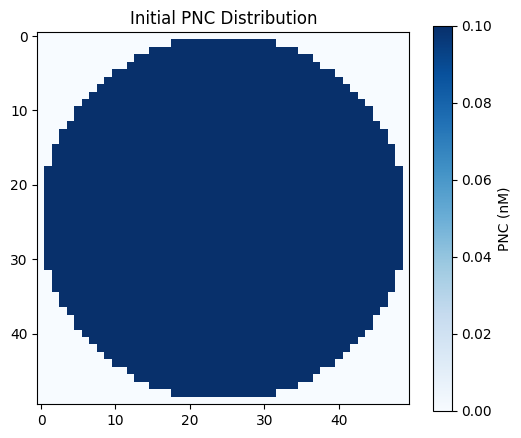

✅ Data saved: model4/baseline_test_1_20250823_092906/Test1_PNC_Baseline_101202/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test1_PNC_Baseline_101203/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test1_PNC_Baseline_101203/data.json
✅ Test run saved to BigQuery: e141a342-1077-430a-88f9-69f1403e5f1d
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test1_PNC_Baseline_101203, BQ test_id=e141a342-1077-430a-88f9-69f1403e5f1d
✅ Saved to cloud: model4/baseline_test_1_20250823_092906/Test1_PNC_Baseline_101203


In [63]:
# %% Cell 2: Test PNC Baseline Initialization
print("="*40)
print("TEST 1: PNC Baseline Initialization")
print("-"*40)

initial_pnc = np.max(model.pnc_field) * 1e9
mean_pnc = np.mean(model.pnc_field[model.active_mask]) * 1e9

print(f"Initial PNC concentration:")
print(f"  Peak: {initial_pnc:.3f} nM")
print(f"  Mean: {mean_pnc:.3f} nM")

if initial_pnc > 0:
    print("✅ PNC baseline properly initialized")
else:
    print("❌ PNC baseline NOT initialized - Check that pnc_baseline is set!")

# Visualize initial PNC field
plt.figure(figsize=(6, 5))
plt.imshow(model.pnc_field * 1e9, cmap='Blues')
plt.colorbar(label='PNC (nM)')
plt.title('Initial PNC Distribution')
plt.show()

results_test1 = {
    'test_name': 'PNC_Baseline_Initialization',
    'initial_pnc': initial_pnc,
    'mean_pnc': mean_pnc,
    'pnc_field': model.pnc_field.copy(),
    'peak_nM': np.max(model.pnc_field) * 1e9,
    'mean_nM': np.mean(model.pnc_field) * 1e9,
    'grid_size': model.pnc_field.shape,
    'test_passed': initial_pnc > 0
}
save_results_and_figures(results_test1, "Test1_PNC_Baseline")
saved_path = save_results_and_figures(results_test1, "Test1_PNC_Baseline")

base_path, test_id = save_results_with_bigquery(results_test1, "Test1_PNC_Baseline")
print(f"✅ Saved to cloud: {saved_path}")

TEST 2: Calcium Microdomains
----------------------------------------
Channel 0 open at position: (25, 25)
Calcium concentrations:
  Baseline: 0 nM
  Peak: 9690 µM
  Mean: 2203 µM
  Near membrane: 4399 µM
✅ Calcium microdomains working
✅ Data saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101209/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101209/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101210/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101210/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101210/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101210/figure.png
✅ Test run saved to BigQuery: 5b955774-8d54-4d95-bad1-7a93b9637629
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test2_Calcium_Microdomains_101210, BQ tes

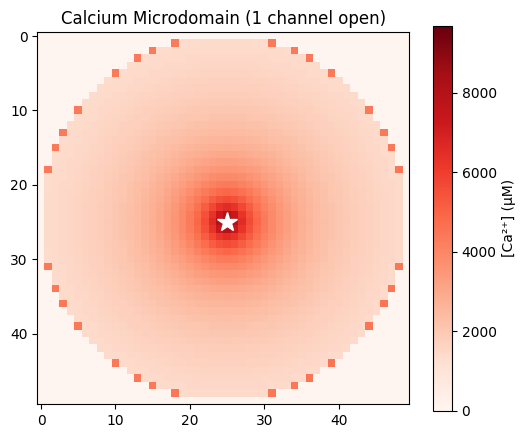

In [64]:
# %% Cell 3: Test Calcium Microdomains
print("="*40)
print("TEST 2: Calcium Microdomains")
print("-"*40)

# Open first channel
model.channels.states[0] = 1
channel_open = model.channels.get_open_channels()

# Calculate microdomains
calcium = model.calculate_calcium_microdomains(channel_open)

print(f"Channel 0 open at position: {model.channel_indices[0]}")
print(f"Calcium concentrations:")
print(f"  Baseline: {params.ca_baseline*1e6:.0f} nM")
print(f"  Peak: {np.max(calcium)*1e6:.0f} µM")
print(f"  Mean: {np.mean(calcium[model.active_mask])*1e6:.0f} µM")

# Check membrane enhancement
membrane_ca = np.mean(calcium[model.membrane_mask]) * 1e6 if np.any(model.membrane_mask) else 0
print(f"  Near membrane: {membrane_ca:.0f} µM")

if np.max(calcium) > 100e-6:  # Should reach >100 µM
    print("✅ Calcium microdomains working")
else:
    print("❌ Calcium microdomains too weak - Check channel current and diffusion")

# Visualize calcium field
plt.figure(figsize=(6, 5))
plt.imshow(calcium * 1e6, cmap='Reds')
plt.colorbar(label='[Ca²⁺] (µM)')
plt.title('Calcium Microdomain (1 channel open)')
# Mark the open channel
ci, cj = model.channel_indices[0]
plt.plot(ci, cj, 'w*', markersize=15)

results_test2 = {
    'test_name': 'Calcium_Microdomains',
    'channel_open': channel_open,
    'calcium_field': calcium.copy() if 'calcium' in locals() else None,
    'calcium_baseline_nM': params.ca_baseline * 1e9,
    'peak_calcium_uM': np.max(calcium) * 1e6 if 'calcium' in locals() else None,
    'mean_calcium_uM': np.mean(calcium) * 1e6 if 'calcium' in locals() else None,
    'near_membrane_ca': membrane_ca if 'membrane_ca' in locals() else None,
    'channel_positions': model.channel_indices if hasattr(model, 'channel_indices') else None,
    'test_passed': np.max(calcium) > 100e-6 if 'calcium' in locals() else False
}
save_results_and_figures(results_test2, "Test2_Calcium_Microdomains")
saved_path = save_results_and_figures(results_test2, "Test2_Calcium_Microdomains")

base_path, test_id = save_results_with_bigquery(results_test2, "Test2_Calcium_Microdomains")
print(f"✅ Saved to cloud: {saved_path}")

plt.show()

TEST 3: Activity-Dependent pH
----------------------------------------
Resting state:
  pH: 7.30
  f(HPO₄²⁻): 0.557
Active state:
  pH: 7.00
  f(HPO₄²⁻): 0.387
  pH change: -0.300
✅ pH modulation working
✅ Data saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101220/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101220/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101220/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101220/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101221/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101221/figure.png
✅ Test run saved to BigQuery: ecdf86c2-2a23-45e8-8bb9-ac9bf52a772e
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test3_pH_Modulation_101221, BQ test_id=ecdf86c2-2a23-45e8-8bb9-ac9bf52a772e
✅ Saved to cloud: model4/baseline_test_

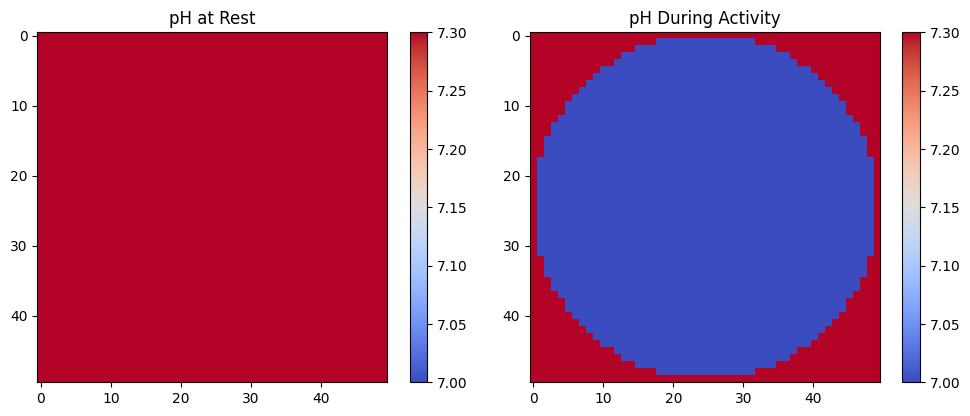

In [65]:
# %% Cell 4: Test Activity-Dependent pH
print("="*40)
print("TEST 3: Activity-Dependent pH")
print("-"*40)

# Test pH change with activity
model.update_local_pH(activity_level=0)
pH_rest = np.mean(model.local_pH[model.active_mask])
f_hpo4_rest = np.mean(model.f_hpo4_local[model.active_mask])

model.update_local_pH(activity_level=1.0)
pH_active = np.mean(model.local_pH[model.active_mask])
f_hpo4_active = np.mean(model.f_hpo4_local[model.active_mask])

print(f"Resting state:")
print(f"  pH: {pH_rest:.2f}")
print(f"  f(HPO₄²⁻): {f_hpo4_rest:.3f}")

print(f"Active state:")
print(f"  pH: {pH_active:.2f}")
print(f"  f(HPO₄²⁻): {f_hpo4_active:.3f}")
print(f"  pH change: {pH_active - pH_rest:.3f}")

if abs(pH_active - pH_rest) > 0.1:
    print("✅ pH modulation working")
else:
    print("❌ pH modulation not working - Check ph_activity_shift parameter")

# Visualize pH fields
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

model.update_local_pH(0)
im1 = axes[0].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[0].set_title('pH at Rest')
plt.colorbar(im1, ax=axes[0])

model.update_local_pH(1.0)
im2 = axes[1].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[1].set_title('pH During Activity')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()

results_test3 = {
    'test_name': 'Activity_Dependent_pH',
    'pH_rest': pH_rest,
    'pH_active': pH_active,
    'f_hpo4_rest': f_hpo4_rest,
    'f_hpo4_active': f_hpo4_active,
    'pH_change': pH_active - pH_rest,
    'local_pH_field': model.local_pH.copy() if hasattr(model, 'local_pH') else None,
    'activity_level': 0,  # explicitly set to 0 for this test
    'test_passed': abs(pH_active - pH_rest) > 0.1
}
save_results_and_figures(results_test3, "Test3_pH_Modulation")
saved_path = save_results_and_figures(results_test3, "Test3_pH_Modulation")

base_path, test_id = save_results_with_bigquery(results_test3, "Test3_pH_Modulation")
print(f"✅ Saved to cloud: {saved_path}")


plt.show()

TEST 4: Template Accumulation
----------------------------------------
✅ Data saved: model4/baseline_test_1_20250823_072036/Test4_Template_Accumulation_072124/data.json
✅ Figure saved: model4/baseline_test_1_20250823_072036/Test4_Template_Accumulation_072124/figure.png
✅ Data saved: model4/baseline_test_1_20250823_072036/Test4_Template_Accumulation_072124/data.json
✅ Figure saved: model4/baseline_test_1_20250823_072036/Test4_Template_Accumulation_072124/figure.png
✅ Saved to cloud: model4/baseline_test_1_20250823_072036/Test4_Template_Accumulation_072124


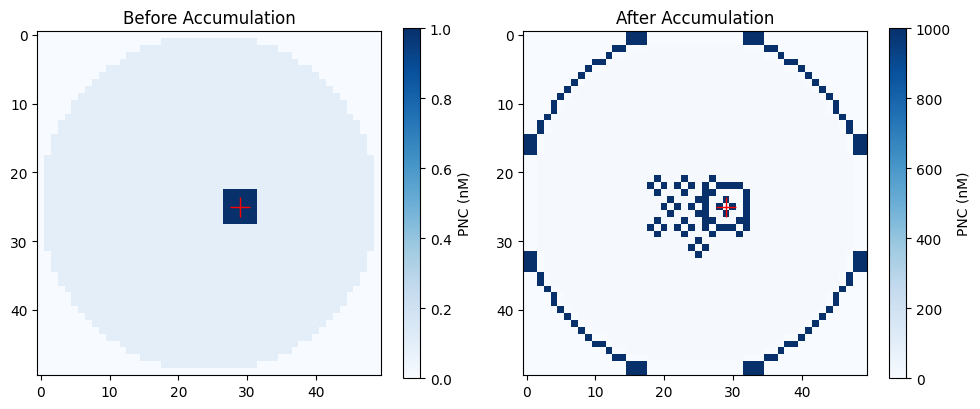

Template at position (29, 25):
  PNC before: 1.000 nM
  PNC after: 0.000 nM
  Bound PNCs: 0.000/3
⚠️ Template accumulation weak - May need longer time or parameter tuning


In [49]:
# %% Cell 5: Test Template Accumulation
print("="*40)
print("TEST 4: Template Accumulation")
print("-"*40)

if len(model.template_indices) > 0:
    ti, tj = model.template_indices[0]
    
    # Add PNCs around template
    for di in [-2, -1, 0, 1, 2]:
        for dj in [-2, -1, 0, 1, 2]:
            ni, nj = ti + di, tj + dj
            if 0 <= ni < params.grid_size and 0 <= nj < params.grid_size:
                model.pnc_field[nj, ni] = 1e-9  # 1 nM
    
    pnc_before = model.pnc_field[tj, ti] * 1e9
    
    # Visualize before
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(model.pnc_field * 1e9, cmap='Blues')
    plt.colorbar(label='PNC (nM)')
    plt.plot(ti, tj, 'r+', markersize=15)
    plt.title('Before Accumulation')
    
    # Run one update step
    model.update_pnc_dynamics(0.001)
    
    pnc_after = model.pnc_field[tj, ti] * 1e9
    binding = model.template_pnc_bound[tj, ti]
    
    # Visualize after
    plt.subplot(1, 2, 2)
    plt.imshow(model.pnc_field * 1e9, cmap='Blues')
    plt.colorbar(label='PNC (nM)')
    plt.plot(ti, tj, 'r+', markersize=15)
    plt.title('After Accumulation')
    plt.tight_layout()


    results_test4 = {
    'test_name': 'Template_Accumulation',
    'pnc_before': pnc_before,
    'pnc_after': pnc_after,
    'binding_sites': params.n_binding_sites if 'params' in locals() else 3,
    'template_indices': model.template_indices if hasattr(model, 'template_indices') else [],
    'template_position': (ti, tj) if 'ti' in locals() and 'tj' in locals() else None,
    'accumulation_ratio': pnc_after / pnc_before if pnc_before > 0 else 0,
    'bound_pncs': binding if 'binding' in locals() else 0,
    'test_passed': pnc_after > pnc_before or binding > 0
    }
    save_results_and_figures(results_test4, "Test4_Template_Accumulation")
    saved_path = save_results_and_figures(results_test4, "Test4_Template_Accumulation")
   
    base_path, test_id = save_results_with_bigquery(results_test4, "Test4_Template_Accumulation")
    print(f"✅ Saved to cloud: {saved_path}")


    
    plt.show()
    
    print(f"Template at position ({ti}, {tj}):")
    print(f"  PNC before: {pnc_before:.3f} nM")
    print(f"  PNC after: {pnc_after:.3f} nM")
    print(f"  Bound PNCs: {binding:.3f}/{params.n_binding_sites}")
    
    if pnc_after > pnc_before or binding > 0:
        print("✅ Template accumulation working")
    else:
        print("⚠️ Template accumulation weak - May need longer time or parameter tuning")
else:
    print("❌ No templates found!")

In [66]:
# %% Cell 6: Test ATP Phosphate Production
print("="*40)
print("TEST 5: ATP-Derived Phosphate")
print("-"*40)

po4_before = np.mean(model.phosphate_field[model.active_mask])

# Open all channels
model.channels.states[:] = 1

# Update phosphate from ATP
model.update_phosphate_from_ATP(0.001, activity_level=1.0)

po4_after = np.mean(model.phosphate_field[model.active_mask])

results_test5 = {
    'test_name': 'ATP_Phosphate_Production',
    'po4_before': po4_before,
    'po4_after': po4_after,
    'po4_change_uM': (po4_after - po4_before) * 1e6,
    'phosphate_field': model.phosphate_field.copy() if hasattr(model, 'phosphate_field') else None,
    'activity_level': 1.0,  # From update_phosphate_from_ATP call
    'test_passed': po4_after > po4_before
}
save_results_and_figures(results_test5, "Test5_ATP_Phosphate")
saved_path = save_results_and_figures(results_test5, "Test5_ATP_Phosphate")

base_path, test_id = save_results_with_bigquery(results_test5, "Test5_ATP_Phosphate")
print(f"✅ Saved to cloud: {saved_path}")


print(f"Phosphate concentration:")
print(f"  Before: {po4_before*1e3:.3f} mM")
print(f"  After: {po4_after*1e3:.3f} mM")
print(f"  Change: {(po4_after-po4_before)*1e6:.3f} µM")

if po4_after > po4_before:
    print("✅ ATP hydrolysis working")
else:
    print("❌ ATP hydrolysis not working - Check k_atp_hydrolysis parameter")

TEST 5: ATP-Derived Phosphate
----------------------------------------
✅ Data saved: model4/baseline_test_1_20250823_092906/Test5_ATP_Phosphate_101229/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test5_ATP_Phosphate_101229/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test5_ATP_Phosphate_101229/data.json
✅ Test run saved to BigQuery: 7b01dbee-cdd6-48fc-9b78-90cb5d40c3d2
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test5_ATP_Phosphate_101229, BQ test_id=7b01dbee-cdd6-48fc-9b78-90cb5d40c3d2
✅ Saved to cloud: model4/baseline_test_1_20250823_092906/Test5_ATP_Phosphate_101229
Phosphate concentration:
  Before: 1.000 mM
  After: 1.000 mM
  Change: 0.092 µM
✅ ATP hydrolysis working


TEST 6: Short Simulation (100 ms)
----------------------------------------
Running simulation for 100 ms...
  Step   0: Posner=0.000 nM, PNC=1000.000 nM, Ca=4477.8 µM
  Step  20: Posner=0.000 nM, PNC=1000.000 nM, Ca=5722.5 µM
  Step  40: Posner=17.973 nM, PNC=1000.000 nM, Ca=4490.3 µM
  Step  60: Posner=17.794 nM, PNC=1000.000 nM, Ca=3539.2 µM
  Step  80: Posner=31.582 nM, PNC=1000.000 nM, Ca=4480.4 µM
✅ Data saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101243/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101243/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101244/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101244/figure.png
✅ Data saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101245/data.json
✅ Figure saved: model4/baseline_test_1_20250823_092906/Test6_Short_Simulation_101245/figure.png
✅ Test run saved to BigQuer

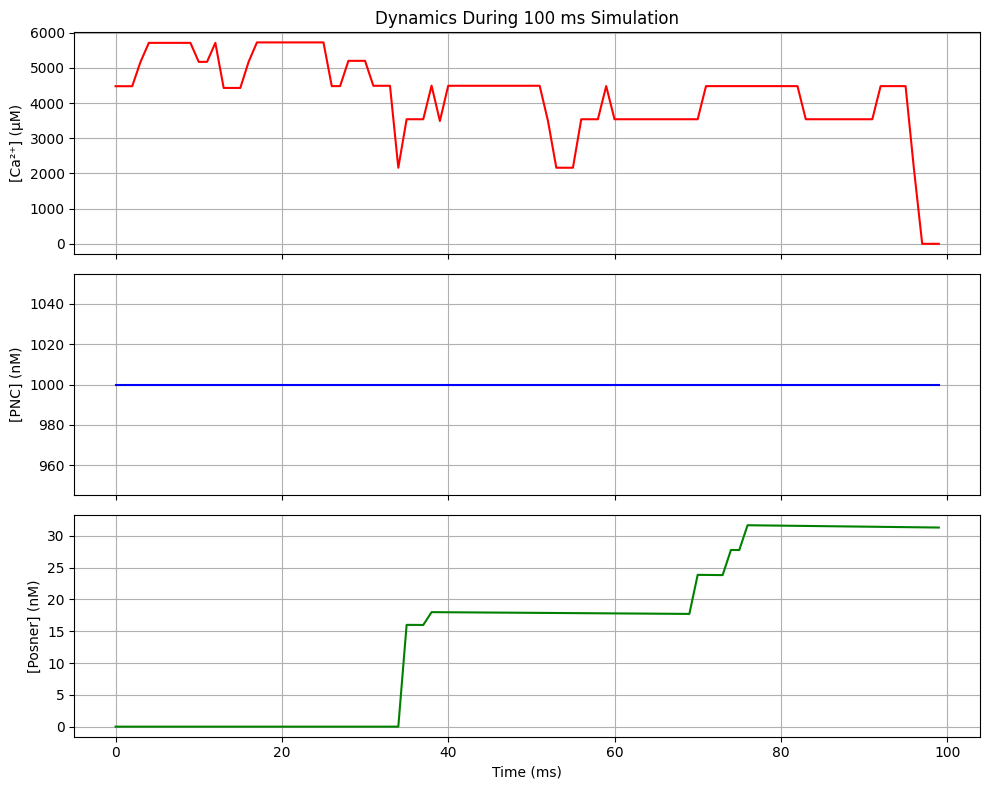


Final results after 100 ms:
  Peak [Posner]: 31.283 nM
  Peak [PNC]: 1000.000 nM
  Fusion events: 15
  Templates occupied: 11


In [67]:
# %% Cell 7: Run Short Simulation
print("="*40)
print("TEST 6: Short Simulation (100 ms)")
print("-"*40)

# Reset model for clean test
model = DynamicNanoreactor(params)

# Track metrics over time
time_points = []
posner_trace = []
pnc_trace = []
calcium_trace = []

print("Running simulation for 100 ms...")
for step in range(100):
    # Update channels
    model.channels.update(params.dt, depolarized=True)
    channel_open = model.channels.get_open_channels()
    
    # Update all fields
    model.update_fields(params.dt, channel_open)
    
    # Record metrics
    time_points.append(step * params.dt * 1000)  # Convert to ms
    posner_trace.append(np.max(model.posner_field) * 1e9)
    pnc_trace.append(np.max(model.pnc_field) * 1e9)
    calcium_trace.append(np.mean(model.calcium_field[model.active_mask]) * 1e6)
    
    if step % 20 == 0:
        print(f"  Step {step:3d}: Posner={posner_trace[-1]:.3f} nM, "
              f"PNC={pnc_trace[-1]:.3f} nM, Ca={calcium_trace[-1]:.1f} µM")

# Plot time traces
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(time_points, calcium_trace, 'r-')
axes[0].set_ylabel('[Ca²⁺] (µM)')
axes[0].set_title('Dynamics During 100 ms Simulation')
axes[0].grid(True)

axes[1].plot(time_points, pnc_trace, 'b-')
axes[1].set_ylabel('[PNC] (nM)')
axes[1].grid(True)

axes[2].plot(time_points, posner_trace, 'g-')
axes[2].set_ylabel('[Posner] (nM)')
axes[2].set_xlabel('Time (ms)')
axes[2].grid(True)

plt.tight_layout()

results_test6 = {
    'test_name': 'Short_Simulation_100ms',
    'time_points': time_points.copy() if 'time_points' in locals() else [],
    'posner_trace': posner_trace.copy() if 'posner_trace' in locals() else [],
    'pnc_trace': pnc_trace.copy() if 'pnc_trace' in locals() else [],
    'calcium_trace': calcium_trace.copy() if 'calcium_trace' in locals() else [],
    'peak_posner_nM': np.max(model.posner_field) * 1e9,
    'peak_pnc_nM': np.max(model.pnc_field) * 1e9,
    'fusion_count': model.fusion_count if hasattr(model, 'fusion_count') else 0,
    'templates_occupied': np.sum(model.template_pnc_bound > 0) if hasattr(model, 'template_pnc_bound') else 0,
    'final_posner_field': model.posner_field.copy() if hasattr(model, 'posner_field') else None,
    'test_passed': np.max(model.posner_field) * 1e9 > 0  # Any Posner formed
}
save_results_and_figures(results_test6, "Test6_Short_Simulation")
saved_path = save_results_and_figures(results_test6, "Test6_Short_Simulation")

base_path, test_id = save_results_with_bigquery(results_test6, "Test6_Short_Simulation")
print(f"✅ Saved to cloud: {saved_path}")


plt.show()

# Final summary
print(f"\nFinal results after 100 ms:")
print(f"  Peak [Posner]: {np.max(model.posner_field)*1e9:.3f} nM")
print(f"  Peak [PNC]: {np.max(model.pnc_field)*1e9:.3f} nM")
print(f"  Fusion events: {model.fusion_count}")
print(f"  Templates occupied: {np.sum(model.template_pnc_bound > 0)}")

TEST 7: Spatial Patterns
----------------------------------------
✅ Data saved: model4/baseline_test_1_20250823_072036/Test7_Spatial_Patterns_072152/data.json
✅ Figure saved: model4/baseline_test_1_20250823_072036/Test7_Spatial_Patterns_072152/figure.png
✅ Data saved: model4/baseline_test_1_20250823_072036/Test7_Spatial_Patterns_072153/data.json
✅ Figure saved: model4/baseline_test_1_20250823_072036/Test7_Spatial_Patterns_072153/figure.png
✅ Saved to cloud: model4/baseline_test_1_20250823_072036/Test7_Spatial_Patterns_072153


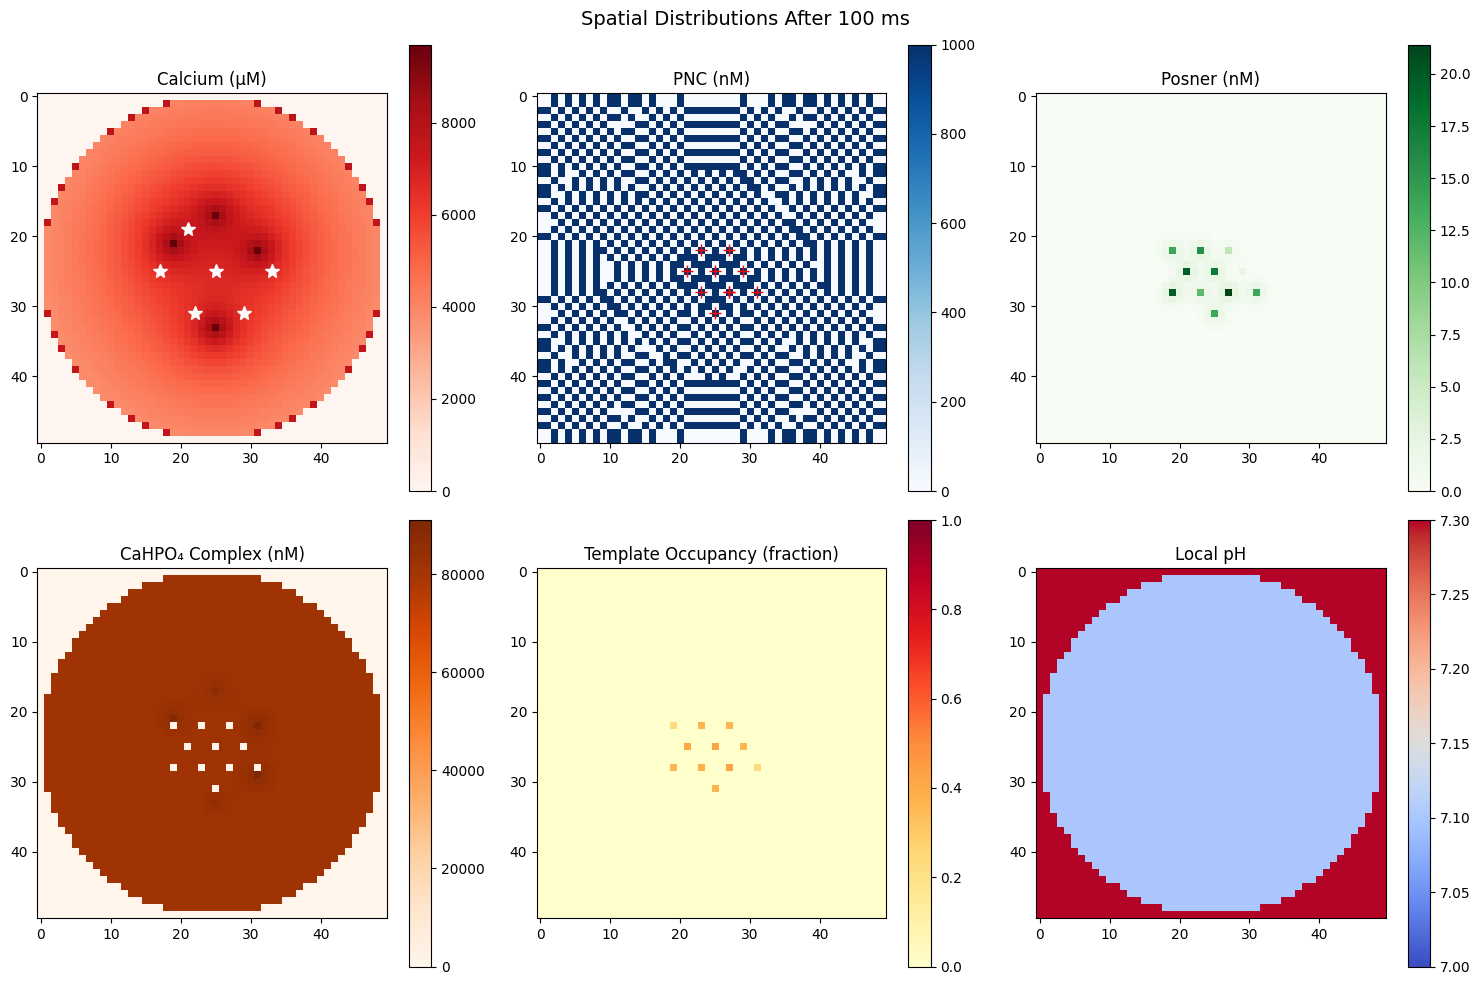

Visualization complete!


In [52]:
# %% Cell 8: Comprehensive Spatial Visualization
print("="*40)
print("TEST 7: Spatial Patterns")
print("-"*40)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Calcium
im1 = axes[0, 0].imshow(model.calcium_field * 1e6, cmap='Reds')
axes[0, 0].set_title('Calcium (µM)')
plt.colorbar(im1, ax=axes[0, 0])

# Mark channels
for ci, cj in model.channel_indices:
    axes[0, 0].plot(ci, cj, 'w*', markersize=10)

# PNC
im2 = axes[0, 1].imshow(model.pnc_field * 1e9, cmap='Blues')
axes[0, 1].set_title('PNC (nM)')
plt.colorbar(im2, ax=axes[0, 1])

# Mark templates (first 10)
for ti, tj in model.template_indices[:10]:
    axes[0, 1].plot(ti, tj, 'r+', markersize=8)

# Posner
im3 = axes[0, 2].imshow(model.posner_field * 1e9, cmap='Greens')
axes[0, 2].set_title('Posner (nM)')
plt.colorbar(im3, ax=axes[0, 2])

# Complex
im4 = axes[1, 0].imshow(model.complex_field * 1e9, cmap='Oranges')
axes[1, 0].set_title('CaHPO₄ Complex (nM)')
plt.colorbar(im4, ax=axes[1, 0])

# Template occupancy
template_occupancy = np.zeros(model.grid_shape)
for ti, tj in model.template_indices:
    template_occupancy[tj, ti] = model.template_pnc_bound[tj, ti] / params.n_binding_sites

im5 = axes[1, 1].imshow(template_occupancy, cmap='YlOrRd', vmin=0, vmax=1)
axes[1, 1].set_title('Template Occupancy (fraction)')
plt.colorbar(im5, ax=axes[1, 1])

# Local pH
im6 = axes[1, 2].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[1, 2].set_title('Local pH')
plt.colorbar(im6, ax=axes[1, 2])

plt.suptitle('Spatial Distributions After 100 ms', fontsize=14)
plt.tight_layout()

results_test7 = {
    'test_name': 'Spatial_Patterns',
    'calcium_field': model.calcium_field.copy() * 1e6,  # in µM
    'pnc_field': model.pnc_field.copy() * 1e9,  # in nM
    'posner_field': model.posner_field.copy() * 1e9,  # in nM
    'complex_field': model.complex_field.copy() * 1e9 if hasattr(model, 'complex_field') else None,
    'template_occupancy': template_occupancy.copy() if 'template_occupancy' in locals() else None,
    'local_pH': model.local_pH.copy() if hasattr(model, 'local_pH') else None,
    'channel_positions': model.channel_indices if hasattr(model, 'channel_indices') else [],
    'template_positions': model.template_indices if hasattr(model, 'template_indices') else [],
    'spatial_stats': {
        'calcium_cv': np.std(model.calcium_field) / np.mean(model.calcium_field) if np.mean(model.calcium_field) > 0 else 0,
        'pnc_cv': np.std(model.pnc_field) / np.mean(model.pnc_field) if np.mean(model.pnc_field) > 0 else 0,
        'posner_cv': np.std(model.posner_field) / np.mean(model.posner_field) if np.mean(model.posner_field) > 0 else 0,
    },
    'test_passed': True  # Visualization test
}
save_results_and_figures(results_test7, "Test7_Spatial_Patterns")
saved_path = save_results_and_figures(results_test7, "Test7_Spatial_Patterns")

base_path, test_id = save_results_with_bigquery(results_test7, "Test7_Spatial_Patterns")
print(f"✅ Saved to cloud: {saved_path}")


plt.show()

print("Visualization complete!")

In [68]:
# %% Cell 9: Summary and Recommendations
print("\n" + "="*60)
print("TESTING SUMMARY")
print("="*60)

# Evaluate results
results = {
    'PNC Baseline': initial_pnc > 0,
    'Calcium Microdomains': np.max(calcium) > 100e-6,
    'pH Modulation': abs(pH_active - pH_rest) > 0.1,
    'Template Accumulation': (pnc_after > pnc_before) or (binding > 0),
    'ATP Hydrolysis': po4_after > po4_before,
    'PNC Formation': np.max(model.pnc_field)*1e9 > 0.1,
    'Posner Formation': (np.max(model.posner_field)*1e9 > 0) or (model.fusion_count > 0)
}

passed = sum(results.values())
total = len(results)

results_test8 = {
    'test_name': 'Testing_Summary',
    'all_results': results.copy() if 'results' in locals() else {},
    'tests_passed': passed,
    'total_tests': total,
    'peak_posner_nM': np.max(model.posner_field) * 1e9 if hasattr(model, 'posner_field') else 0,
    'fusion_probability': params.fusion_probability if 'params' in locals() else 0,
    'k_pnc_formation': params.k_pnc_formation if 'params' in locals() else 0,
    'recommendations': [
        'Run longer simulation (1-10 seconds)',
        'Try tetanic stimulation protocol',
        'Compare isotope effects (31P vs 32P)',
        'Analyze spatial hotspot formation',
        'Test temperature dependence'
    ],
    'test_passed': passed == total
}
save_results_and_figures(results_test8, "Test8_Summary")
saved_path = save_results_and_figures(results_test8, "Test8_Summary")

base_path, test_id = save_results_with_bigquery(results_test8, "Test8_Summary")
print(f"✅ Saved to cloud: {saved_path}")

for test, result in results.items():
    status = "✅ PASSED" if result else "❌ FAILED"
    print(f"{test:.<30} {status}")

print(f"\n📊 Overall: {passed}/{total} tests passed")

if passed == total:
    print("🎉 ALL TESTS PASSED! Model is working correctly.")
elif passed >= 5:
    print("👍 Most tests passed - model is functional but may need tuning.")
else:
    print("⚠️ Several tests failed - debugging needed.")

print("\n💡 Recommendations:")
if np.max(model.posner_field)*1e9 < 10:
    print("  • Run longer simulation (1-10 seconds)")
    print("  • Try tetanic stimulation protocol")
    print("  • Increase fusion_probability (currently {:.3f})".format(params.fusion_probability))
    print("  • Increase k_pnc_formation (currently {:.0f} s⁻¹)".format(params.k_pnc_formation))
    
if np.max(model.pnc_field)*1e9 < 10:
    print("  • Increase k_pnc_formation further")
    print("  • Check calcium levels are sufficient (need >100 µM)")
    print("  • Verify complex formation is working")

print("\n📝 Next steps for production runs:")
print("  1. Save the fixed model code")
print("  2. Run with different stimulation protocols")
print("  3. Compare isotope effects (³¹P vs ³²P)")
print("  4. Analyze spatial hotspot formation")
print("  5. Test temperature dependence")



TESTING SUMMARY
✅ Data saved: model4/baseline_test_1_20250823_092906/Test8_Summary_101303/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test8_Summary_101303/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test8_Summary_101303/data.json
✅ Test run saved to BigQuery: cbed192a-6583-4676-87b7-008ab2359d6f
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test8_Summary_101303, BQ test_id=cbed192a-6583-4676-87b7-008ab2359d6f
✅ Saved to cloud: model4/baseline_test_1_20250823_092906/Test8_Summary_101303
PNC Baseline.................. ✅ PASSED
Calcium Microdomains.......... ✅ PASSED
pH Modulation................. ✅ PASSED
Template Accumulation......... ❌ FAILED
ATP Hydrolysis................ ✅ PASSED
PNC Formation................. ✅ PASSED
Posner Formation.............. ✅ PASSED

📊 Overall: 6/7 tests passed
👍 Most tests passed - model is functional but may need tuning.

💡 Recommendations:

📝 Next steps for production runs:
  1. Save the fixed mode

In [69]:
# %% Cell 10: Quick Parameter Tuning Test (Optional)
print("\n" + "="*60)
print("OPTIONAL: Quick Parameter Tuning")
print("="*60)

# Try with enhanced parameters for faster results
params_enhanced = DynamicParameters()
params_enhanced.k_pnc_formation = 10000.0  # 2x higher
params_enhanced.fusion_probability = 0.1   # 2x higher
params_enhanced.k_pnc_binding = 1e10      # 10x higher

model_enhanced = DynamicNanoreactor(params_enhanced)

print("Testing with enhanced parameters:")
print(f"  k_pnc_formation: {params_enhanced.k_pnc_formation:.0f} s⁻¹")
print(f"  fusion_probability: {params_enhanced.fusion_probability:.2f}")
print(f"  k_pnc_binding: {params_enhanced.k_pnc_binding:.1e} M⁻¹s⁻¹")

# Run for 50 ms
for step in range(50):
    model_enhanced.channels.update(params_enhanced.dt, depolarized=True)
    channel_open = model_enhanced.channels.get_open_channels()
    model_enhanced.update_fields(params_enhanced.dt, channel_open)

print(f"\nResults after 50 ms:")
print(f"  Peak [Posner]: {np.max(model_enhanced.posner_field)*1e9:.3f} nM")
print(f"  Peak [PNC]: {np.max(model_enhanced.pnc_field)*1e9:.3f} nM")
print(f"  Fusion events: {model_enhanced.fusion_count}")

if np.max(model_enhanced.posner_field)*1e9 > np.max(model.posner_field)*1e9:
    print("✅ Enhanced parameters improve formation!")
else:
    print("⚠️ May need different parameter adjustments")


results_test9 = {
    'test_name': 'Parameter_Tuning',
    'enhanced_params': params_enhanced.__dict__ if 'params_enhanced' in locals() else {},
    'baseline_peak_posner': np.max(model.posner_field) * 1e9 if hasattr(model, 'posner_field') else 0,
    'enhanced_peak_posner': np.max(model_enhanced.posner_field) * 1e9 if 'model_enhanced' in locals() else 0,
    'improvement_factor': (np.max(model_enhanced.posner_field) / np.max(model.posner_field)) if 'model_enhanced' in locals() and np.max(model.posner_field) > 0 else 1,
    'test_passed': 'model_enhanced' in locals()
}
save_results_and_figures(results_test9, "Test9_Parameter_Tuning")
saved_path = save_results_and_figures(results_test9, "Test9_Parameter_Tuning")

base_path, test_id = save_results_with_bigquery(results_test9, "Test9_Parameter_Tuning")
print(f"✅ Saved to cloud: {saved_path}")


OPTIONAL: Quick Parameter Tuning
Testing with enhanced parameters:
  k_pnc_formation: 10000 s⁻¹
  fusion_probability: 0.10
  k_pnc_binding: 1.0e+10 M⁻¹s⁻¹

Results after 50 ms:
  Peak [Posner]: 0.000 nM
  Peak [PNC]: 1000.000 nM
  Fusion events: 0
⚠️ May need different parameter adjustments
✅ Data saved: model4/baseline_test_1_20250823_092906/Test9_Parameter_Tuning_101309/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test9_Parameter_Tuning_101310/data.json
✅ Data saved: model4/baseline_test_1_20250823_092906/Test9_Parameter_Tuning_101310/data.json
✅ Test run saved to BigQuery: 77fadded-68b5-4d7f-bc37-934589ae8fb5
✅ Complete save: GCS path=model4/baseline_test_1_20250823_092906/Test9_Parameter_Tuning_101310, BQ test_id=77fadded-68b5-4d7f-bc37-934589ae8fb5
✅ Saved to cloud: model4/baseline_test_1_20250823_092906/Test9_Parameter_Tuning_101310
